This notebook describes the steps necessary to analyze the experimental results and get the plots and tables in the paper. Every cell can be run independently, as the computed data is stored in a temporary directory.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import defaultdict
from functools import reduce
from tqdm import tqdm

import src.utils as u
import src.rank_utils as ru
import src.rank_metrics as rm

## Sensitivty to exerimental factors
Here we compute the similarity matrices for sensitivity to experimental factors

In [2]:
df, rf = u.load_df_rf()

# sensitivity to ML model (model), tuning strategy (tuning), and quality metric (scoring) respectively. The other factors are fixed.
jaccard_model, rho_model = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                             shared_levels=[0, 2, 3])
jaccard_tuning, rho_tuning = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                               shared_levels=[0, 1, 3])
jaccard_scoring, rho_scoring = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                                 shared_levels=[0, 1, 2])

jaccard = reduce(lambda x, y: x.fillna(y), [jaccard_model, jaccard_tuning, jaccard_scoring])
rho = reduce(lambda x, y: x.fillna(y), [rho_model, rho_tuning, rho_scoring])

jaccard.to_csv(u.RANKINGS_DIR / "pw_jaccard.csv")
rho.to_csv(u.RANKINGS_DIR / "pw_rho.csv")

And now we can plot it

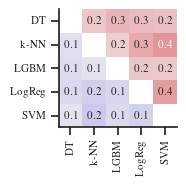

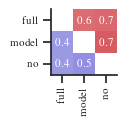

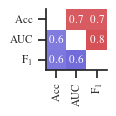

In [11]:
sims = u.load_similarity_dataframes()
rho = sims["pw_rho.csv"]
jaccard = sims["pw_jaccard.csv"]

factors = ["model", "tuning", "scoring"]
similarities = ["rho", "jaccard"]

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

for factor in factors:
    df_sim = u.join_wide2long({"jaccard": jaccard, "rho": rho}, comparison_level=factor)
    title = None
    if factor == "model":
        figsize = (1.8, 1.8)
    elif factor == "tuning":
        figsize = (1.2, 1.2)
    elif factor == "scoring":
        figsize = (1.1, 1.1)
    else:
        raise AssertionError(f"{factor} is an invalid factor.")

    u.heatmap_longformat_multisim(df_sim, similarities, factor, fontsize=8, annot_fontsize=8,
                                  figsize=figsize,
                                  save_plot=False, show_plot=True, title=title,)

plt.show()

### Interpretation sensitivity

First compute aggregations

In [ ]:
# --- Aggregation for all aggregation strategies except Nemenyi
a = ru.Aggregator(df, rf)
a.aggregate(verbose=True, ignore_strategies=["nemenyi rank"])
a.to_csv(u.TMP_DIR / "consensuses_no_nemenyi.csv")

# --- Test multiple alphas, then concatenate everything together
for alpha in [0.01, 0.05, 0.1]:
    a = ru.Aggregator(df, rf)
    a.aggregate(verbose=True, strategies=["nemenyi rank"], alpha=alpha)
    a.to_csv(u.TMP_DIR / f"consensus_nemenyi_{alpha}.csv")

# --- concatenate
aggrf = pd.read_csv(u.TMP_DIR / "consensuses_no_nemenyi.csv", index_col=0,
                    header=[0, 1, 2, 3])
agg_nemenyi = [
    pd.read_csv(u.TMP_DIR / f"consensus_nemenyi_{alpha}.csv", index_col=0, header=[0, 1, 2, 3])
    for alpha in [0.01, 0.05, 0.1]
]

aggrf = pd.concat(agg_nemenyi.extend([aggrf]) or agg_nemenyi, axis=1)
aggrf.to_csv(u.RANKINGS_DIR / "consensuses.csv")

Then, compute similarity between aggregations

In [ ]:
aggrf = u.load_aggrf().rename(columns=u.AGGREGATION_NAMES, level="aggregation")
agg_jaccard, agg_rho = u.pairwise_similarity_wide_format(aggrf,
                                                         simfuncs=[rm.jaccard_best,
                                                                   rm.spearman_rho],
                                                         shared_levels=slice(-1))

agg_jaccard.to_csv(u.RANKINGS_DIR / "pw_AGG_jaccard.csv")
agg_rho.to_csv(u.RANKINGS_DIR / "pw_AGG_rho.csv")

And finally plot it

In [ ]:
aggsims = u.load_agg_similarities()
agg_jaccard = aggsims["pw_AGG_jaccard.csv"]
agg_rho = aggsims["pw_AGG_rho.csv"]

df_sim = u.join_wide2long({"rho": agg_rho, "jaccard": agg_jaccard}, comparison_level="aggregation")

sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, ax = plt.subplots(1, 1, figsize=(3, 3.3))
u.heatmap_longformat_multisim(df_sim, ["rho", "jaccard"], "aggregation", fontsize=7, annot_fontsize=7,
                              save_plot=True, show_plot=True, ax=ax, summary_statistic="mean", title=None)

### Replicability

Replicability is compute by sampling two disjoint sets of datasets, aggregating on those subsets, and finally computing the similarity of hte two consensuses. This process is repeated for various sample sizes 100 each.
We do not use Kemeny aggregatio as it taks a long time. Results are for different tuning as the number of datasets differs.
Perfect replicability is 1.


In [ ]:
df, rf = u.load_df_rf()

tuning = "no"
df_ = df.query("tuning == @tuning")
rf_ = rf.loc(axis=1)[:, :, tuning, :].copy()

sample_df_sim = u.load_sample_similarity_dataframe(tuning=tuning)
run = True
if run:
    # whenever we add experiments, start from the value of seed
    seed = 0
    sample_sizes = [5, 10, 15, 20, 25]
    repetitions = 20
    mat_corrs = []
    sample_aggregators = defaultdict(lambda: [])
    for sample_size in tqdm(sample_sizes):
        inner_mat_corrs = []
        inner_sample_aggregators = []
        for _ in tqdm(range(repetitions)):
            seed += 1
            a = ru.SampleAggregator(df_, rf_, sample_size, seed=seed, bootstrap=True).aggregate(ignore_strategies=["kemeny rank"],
                                                                                                verbose=False)

            tmp_jaccard, tmp_rho = u.pairwise_similarity_wide_format(a.aggrf,
                                                                     simfuncs=[rm.jaccard_best,
                                                                               rm.spearman_rho])
            agg_sample_long = u.join_wide2long(dict(zip(["jaccard", "rho"],
                                                        [tmp_jaccard, tmp_rho])),
                                               comparison_level="sample")

            inner_mat_corrs.append(agg_sample_long.assign(sample_size=sample_size).query("sample_1 < sample_2"))
            sample_aggregators[sample_size].append(a)
        mat_corrs.append(pd.concat(inner_mat_corrs, axis=0))
    # if mat_corr is already defined, make it bigger! We are adding experiments
    mat_corr = pd.concat(mat_corrs, axis=0)
    mat_corr = mat_corr.join(
        mat_corr.groupby(["aggregation", "sample_size"])[["jaccard", "rho"]].std(),
        on=["aggregation", "sample_size"], rsuffix="_std")
    sample_df_sim = pd.concat([sample_df_sim, mat_corr], axis=0)

# rename to AGGREGATION_NAMES but allow correctly formatted names
sample_df_sim.aggregation = sample_df_sim.aggregation.map(lambda x: defaultdict(lambda: x, u.AGGREGATION_NAMES)[x])
sample_df_sim.to_csv(u.RANKINGS_DIR / f"sample_sim_{tuning}.csv", index=False)

And finally plot everything!

In [ ]:
sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig = plt.figure(figsize=(5.5, 3))
gs = fig.add_gridspec(2, 3)

hue = "aggregation"

for isim, sim in enumerate(["rho", "agrbest"]):
    for itun, tuning in enumerate(["no", "model", "full"]):
        sample_df_sim = u.load_sample_similarity_dataframe(tuning=tuning)

        xb = (sim == "agrbest")
        yl = (tuning == "no")

        with sns.axes_style("ticks", {"xtick.bottom": True, "ytick.left": True}):
            ax = fig.add_subplot(gs[isim, itun])

            u.lineplot_longformat_sample_sim(sample_df_sim, similarity=sim, save_plot=False, show_plot=False,
                                             hue=hue,
                                             estimator="mean",
                                             ax=ax,
                                             )
        if not xb:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
        if not yl:
            ax.set_ylabel(None)
            ax.set_yticklabels([])

        ax.grid(axis="y", zorder=-1, linewidth=0.4)

        if tuning == "no":
            handles, labels = ax.get_legend_handles_labels()

        ax.legend().remove()

        if sim == "rho":
            ax.set_title(f"{tuning} tuning")

    plt.tight_layout(w_pad=3, h_pad=1)

    ## hue = model
    # plt.subplots_adjust(top=0.86)
    # plt.figlegend(
    #     handles=handles,
    #     labels=labels,
    #     bbox_to_anchor=(0, 0.86+0.02, 1, 0.2),
    #     loc="lower left",
    #     mode="expand",
    #     borderaxespad=1,
    #     ncol=5,
    #     frameon=False
    # )

    ## hue = aggregation
    plt.subplots_adjust(top=0.8)
    plt.figlegend(
        handles=handles,
        labels=labels,
        bbox_to_anchor=(0, 0.8+0.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=1,
        ncol=5,
        frameon=False
    )

    # hue = scoring
    # plt.subplots_adjust(top=0.86)
    # plt.figlegend(
    #     handles=handles,
    #     labels=labels,
    #     bbox_to_anchor=(0, 0.86+0.02, 1, 0.2),
    #     loc="lower center",
    #     # mode="expand",
    #     borderaxespad=1,
    #     ncol=3,
    #     frameon=False
    # )

sns.despine(trim=True)

## Rank of encoders


In [ ]:
rf = u.load_rf()

rf_melt = rf.melt(ignore_index=False).reset_index()
rf_melt.columns = ["encoder", "dataset", "model", "tuning", "scoring", "rank"]
rf_melt.encoder = rf_melt.encoder.map(u.ENCODER_LATEX)

sns.set(font_scale=0.8)
sns.set_style("ticks", {"ytick.left": False})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')


fig, ax = plt.subplots(1, 1, figsize=(1.8, 4.4))
ax = u.sorted_boxplot_horizontal(data=rf_melt, y="encoder", x="rank", order_by="mean",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                 },
                                 ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.set_xlim(0, 32)
ax.set_xticks([0, 10, 20, 30])
ax.grid(axis="x", zorder=-1, linewidth=0.4)
# ax.set_title("(c) All models")

sns.despine(left=True, trim=True)
plt.tight_layout(w_pad=0.5)

In [ ]:
rf = u.load_rf()

model = "KNC"
rf = rf.loc(axis=1)[:, model, :, :]

rf_melt = rf.melt(ignore_index=False).reset_index()
rf_melt.columns = ["encoder", "dataset", "model", "tuning", "scoring", "rank"]
rf_melt.encoder = rf_melt.encoder.map(u.ENCODER_LATEX)

sns.set(font_scale=0.8)
sns.set_style("ticks", {"ytick.left": False})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')


fig, ax = plt.subplots(1, 1, figsize=(1.8, 4.4))
ax = u.sorted_boxplot_horizontal(data=rf_melt, y="encoder", x="rank", order_by="mean",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                 },
                                 ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.set_xlim(0, 32)
ax.set_xticks([0, 10, 20, 30])
ax.grid(axis="x", zorder=-1, linewidth=0.4)

sns.despine(left=True, trim=True)
plt.tight_layout(w_pad=0.5)